# Evaluate

This notebook takes a trained road segmentation network (i.e., the output of `TrainTiramisu.ipynb`), evaluates it against a full image, and converts the output into a raster of the predicted road centerlines.

Though there are a lot of issues remaining (lots of breaks / gaps in the predicted map, spurious short branches, etc), I'd call it a moderate success:
![final result](plots/final_output_RGB-PanSharpen_AOI_2_Vegas_img944.png)

## imports

In [1]:
from os import path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from keras.models import load_model
import rasterio
from skimage import morphology

Using TensorFlow backend.


## load model and declare helper functions

In [2]:
model = load_model('snapshots/run-01/modelweights.85-0.18.hdf5')

In [3]:
def _make_transparent(cmap):
    # custom colormaps that are transparent at low values
    my_cmap = cmap(np.arange(cmap.N))
    my_cmap[:, -1] = np.zeros_like(my_cmap[:, -1])
    my_cmap[-1:, -1] = 0.75
    my_cmap = ListedColormap(my_cmap)
    return my_cmap

#### tile the input image for network consumption

In [4]:
def tile_generator(img_data, tile_size):
    """
    Take in a full-size image and yield tiles of a given size.
    At the boundaries, will pad the image data with zeros to fill
      out the full tile shape.
    Note: our network handles zeros gracefully, since it saw some
      empty tiles during training.
    """
    for row_start in np.arange(0, img_data.shape[0], tile_size[0]):
        for col_start in np.arange(0, img_data.shape[1], tile_size[1]):
            output = img_data[row_start: row_start + tile_size[0],
                              col_start: col_start + tile_size[1]]
            if output.shape != tile_size:
                # we've gone off the edge
                row_diff = tile_size[0] - output.shape[0]
                col_diff = tile_size[1] - output.shape[1]
                output = np.pad(output, ((0, row_diff), (0, col_diff), (0, 0)),
                                mode='constant', constant_values=0)
            yield output

def rebuild_array(tiles, img_shape, tile_size):
    """
    Rebuild a complete array from a set of tiles pulled out of a complete image.
    Tightly coupled to tile_generator, above.
    """
    tiles_per_row = int(np.ceil(img_shape[0] / tile_size[0]))
    tiles_per_col = int(np.ceil(img_shape[1] / tile_size[1]))
    full_array = np.zeros((tiles_per_row * tile_size[0],
                           tiles_per_col * tile_size[1]))
    tile_idx = 0
    for row_idx in range(tiles_per_row):
        for col_idx in range(tiles_per_col):
            row_start = row_idx * tile_size[0]
            col_start = col_idx * tile_size[1]
            full_array[row_start: row_start + tile_size[0],
                       col_start: col_start + tile_size[1]] = tiles[tile_idx]
            tile_idx += 1
    # crop back down to the input image size
    return full_array[:img_shape[0], :img_shape[1]]

def _reshape_output(output_array, img_shape):
    _reshaped = np.argmax(output_array[0], axis=-1)
    _reshaped = _reshaped.reshape(img_shape[0], img_shape[1])
    return _reshaped

# run through a complete image

In [5]:
data_dir = '../../data/val/RGB-PanSharpen'
img_name = 'RGB-PanSharpen_AOI_2_Vegas_img944.tif'

img_file = rasterio.open(path.join(data_dir, img_name))
img_data = np.rollaxis(img_file.read(), 0, 3)
tile_size = model.input_shape[1:3]

In [6]:
tile_predictions = []
for tile in tile_generator(img_data, tile_size):
    # network needs input with an extra dimension on the front, for batch size
    network_input = (tile / 2048.)[np.newaxis, :]
    network_output = model.predict(network_input)
    pred = _reshape_output(network_output, tile_size)
    tile_predictions.append(pred)

full_network_prediction = rebuild_array(tile_predictions, img_data.shape, tile_size)

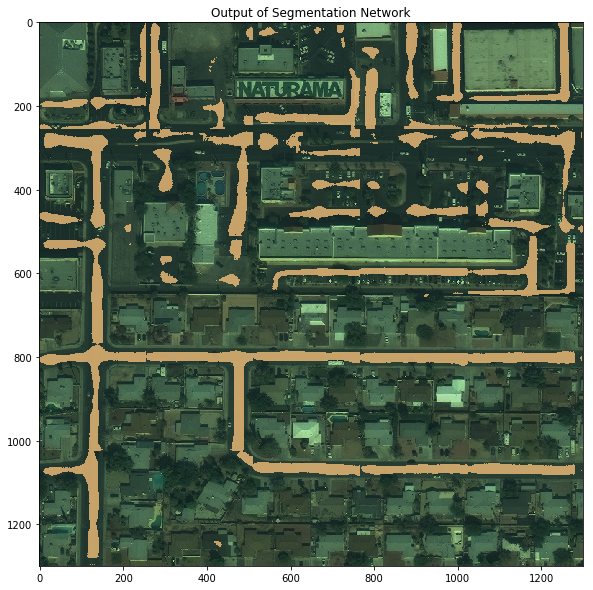

In [7]:
plt.figure(figsize=(10, 10))
plt.imshow(img_data / 2048.)
plt.imshow(full_network_prediction,
           cmap=_make_transparent(plt.cm.copper), vmin=0, vmax=1)
_ = plt.title('Output of Segmentation Network')

# postprocessing / cleanup

Use a [morphological closing](https://en.wikipedia.org/wiki/Closing_(morphology)) operation to clean up the network output a bit, and then predict the centerlines via a [mophological skeletonization](https://en.wikipedia.org/wiki/Morphological_skeleton) operation.

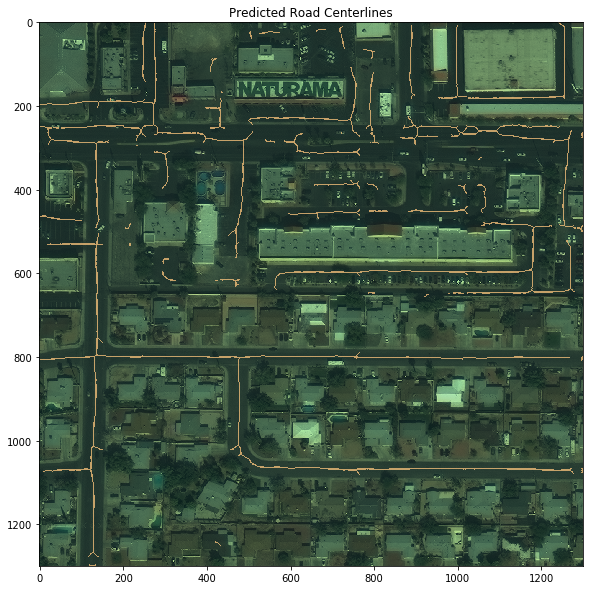

In [8]:
roads = morphology.binary_closing(full_network_prediction,
                                  selem=morphology.disk(5))
road_centerlines = morphology.skeletonize(roads)

plt.figure(figsize=(10, 10))
plt.imshow(img_data / 2048.)
## to examine the effect of the closing operation:
# plt.imshow(roads, cmap=_make_transparent(plt.cm.Reds), vmin=0, vmax=1)

# Here I dilate the centerlines just to make them visible in the plot:
_centerlines = morphology.binary_dilation(road_centerlines,
                                          selem = morphology.disk(1))

plt.imshow(_centerlines, cmap=_make_transparent(plt.cm.copper), vmin=0, vmax=1)
_ = plt.title('Predicted Road Centerlines')
plt.savefig('plots/final_output_{}'.format(img_name.replace('.tif', '.png')))